In [48]:
import cv2
import torch
import random
import csv
import time
import copy

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [49]:
class O_net_Dataset(Dataset):
    def __init__(self, path, transform=None):
        with open(path, 'r') as f:
            self.lines = f.readlines()
        self.transform = transform
        
    def __len__(self):
        return len(self.lines)
    
    def __getitem__(self, idx):
        line = self.lines[idx].strip().split()

        img_path, label, offset = line[0], line[1], line[2:6]
        
        if len(line) > 6:
            landmarks = np.array([float(x) for x in line[6:]])
        else:
            landmarks = np.zeros(10)
        
        img = Image.open(img_path).convert('RGB')
        label = int(label)
        offset = np.array([float(x) for x in offset])
        
        sample = {'image': img, 'label': label, 'offset': offset, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [50]:
class ToTensor:
    def __call__(self, sample):
        image, label, offset, landmarks = sample.values()
        
        image = transforms.ToTensor()(image)
        label = torch.from_numpy(np.array(label)).float()
        offset = torch.from_numpy(offset).float()
        landmarks = torch.from_numpy(landmarks).float()
        
        return {'image': image, 'label': label, 'offset': offset, 'landmarks': landmarks}

In [51]:
path = './anno_store/imglist_anno_48.txt'

img_show = O_net_Dataset(path)

[8565, 13848, 3237, 25957, 345]
[0, -1, 0, -2, 0]
[array([0., 0., 0., 0.]), array([ 0.14, -0.09, -0.12, -0.11]), array([0., 0., 0., 0.]), array([ 0.115, -0.101, -0.037,  0.005]), array([0., 0., 0., 0.])]


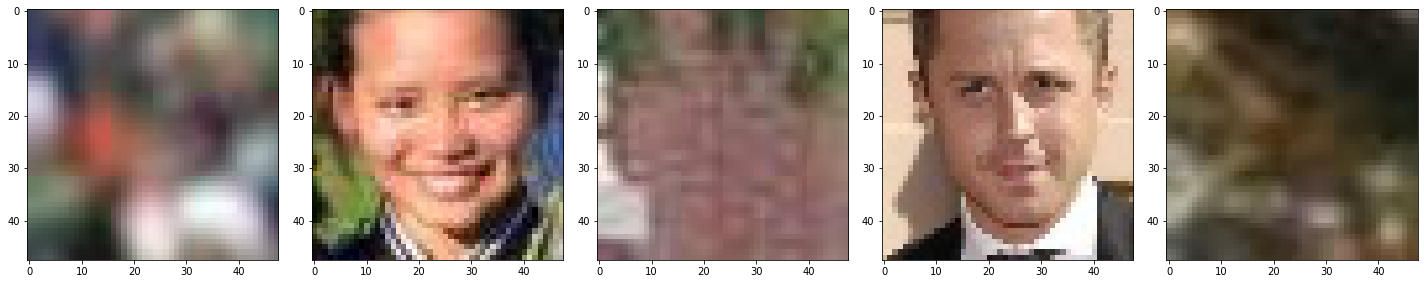

In [52]:
def my_show(data, nums):
    fig = plt.figure(figsize=(20, 5))
    lst = []
    labels = []
    offsets = []
    
    for i in range(nums):
        ax = plt.subplot(1, nums, i + 1)
        plt.tight_layout()
        
        n = random.randint(0, len(data))
        img, label, offset, landmarks = data[n].values()
        
        lst.append(n)
        labels.append(label)
        offsets.append(offset)
        
        ax.imshow(np.array(img))
        
    print(lst)
    print(labels)
    print(offsets)
    
my_show(img_show, 5)


In [53]:
class ONet(nn.Module):

    def __init__(self):
        super(ONet, self).__init__()

        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1),  
            nn.PReLU(),  
            nn.MaxPool2d(kernel_size=3, stride=2),  
            nn.Conv2d(32, 64, kernel_size=3, stride=1),  
            nn.PReLU(), 
            nn.MaxPool2d(kernel_size=3, stride=2),  
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  
            nn.PReLU(), 
            nn.MaxPool2d(kernel_size=2,stride=2), 
            nn.Conv2d(64,128,kernel_size=2,stride=1), 
            nn.PReLU() 
        )
        self.conv5 = nn.Linear(128*2*2, 256)  # conv5
        self.prelu5 = nn.PReLU()  # prelu5

        self.conv6_1 = nn.Linear(256, 1)
   
        self.conv6_2 = nn.Linear(256, 4)
    
        self.conv6_3 = nn.Linear(256, 10)
 

    def forward(self, x):
   
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv5(x)
        x = self.prelu5(x)
      
        det = torch.sigmoid(self.conv6_1(x))
        box = self.conv6_2(x)
        landmark = self.conv6_3(x)

        return det, box, landmark

In [192]:
def train_onet(model_path, epoch, data_path, trfm, batch_size ,lr):

    
    dataset = O_net_Dataset(data_path, trfm)
    train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    onet = ONet()
#     weight = torch.FloatTensor([1, 4])
    criterion_cls = nn.BCELoss()
    criterion_box = nn.MSELoss()
    criterion_landmark = nn.MSELoss()
    optimizer = optim.Adam(onet.parameters(), lr=lr)
    
    since = time.time()
    best_model_wts = copy.deepcopy(onet.state_dict())
    best_valid_loss = float('inf')
    
    t = 0
    
    for epoch_idx in range(epoch):
        onet.train()
        epoch_time = time.time()
        loss_label_totle = 0.0
        loss_offset_totle = 0.0
        loss_landmark_totle = 0.0
        acc_positive = 0.0
        acc_negative = 0.0
        times = 0
        
        for batch_idx, batch in enumerate(train_dataloader):
            image, label, offset, landmarks = batch.values()
            if label.size(0) < batch_size:
                continue
            
            p_label, p_offset, p_landmarks = onet(image)
            p_label = torch.squeeze(p_label)
        
            gt_label = label[label >= 0]
            pre_label = p_label[label >= 0]
            
            mask = torch.where((label == -1) | (label == 1))
            gt_offset = offset[mask]
            pre_offset = p_offset[mask]
            
            gt_landmark = landmarks[label == -2]
            pre_landmark = p_landmarks[label == -2]
            

            loss_cls = criterion_cls(pre_label, gt_label)
            loss_box = criterion_box(pre_offset, gt_offset)
            loss_landmark = criterion_landmark(pre_landmark, gt_landmark)          
            
            loss = 0.8 * loss_cls + 0.6 * loss_box + 1.5 * loss_landmark
            

  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 统计
#             _, pred = torch.max(pre_label, 1)
            pred = torch.ge(pre_label, 0.6).float()
            
            acc_positive += (gt_label[gt_label == 1] == pred[gt_label == 1]).sum().item() / (gt_label[gt_label == 1].size(0) + 0.001)
            acc_negative += (gt_label[gt_label == 0] == pred[gt_label == 0]).sum().item() / (gt_label[gt_label == 0].size(0) + 0.001)
            
            loss_label_totle += (loss_cls * 0.8).item()
            loss_offset_totle += (loss_box * 0.6).item()
            loss_landmark_totle += (loss_landmark * 1.5).item()
            times += 1
        
        loss_label_totle /= times
        loss_offset_totle /= times
        loss_landmark_totle /= times
        loss_totle = loss_label_totle + loss_offset_totle + loss_landmark_totle
        acc_positive /= times
        acc_negative /= times
        t = time.time() - epoch_time
        
        if epoch_idx % 1 == 0:
            print('Epoch {} spend: {:.0f}m {:.0f}s'.format(epoch_idx, t // 60, t % 60))
            print('Valid: loss_totle: {:.4f} loss_label: {:.4f} loss_offset: {:.4f} loss_landmark: {:.4f}'.format(
                loss_totle, loss_label_totle, loss_offset_totle, loss_landmark_totle))
            print('Label: acc_positive: {:.4f}, acc_negative: {:.4f}'.format(acc_positive, acc_negative))
            print('-' * 20)
            
        if loss_totle < best_valid_loss:
            best_model_wts = copy.deepcopy(onet.state_dict())
            best_valid_loss = loss_totle
    
    onet.load_state_dict(best_model_wts)
    time_elapesd = time.time() - since
    torch.save(onet.state_dict(), model_path)
    
    print('=' * 50)
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapesd // 60, time_elapesd % 60))
    print('Best val loss: {:4f}'.format(best_valid_loss))


In [193]:
model_path = './model_store/onet.pkl'
data_path = './anno_store/imglist_anno_48.txt'
trfm = transforms.Compose([ToTensor()])
batch_size = 128
lr = 0.003
epoch = 20

In [194]:
train_onet(model_path, epoch, data_path, trfm, batch_size ,lr)

Epoch 0 spend: 1m 29s
Valid: loss_totle: 0.4014 loss_label: 0.3664 loss_offset: 0.0135 loss_landmark: 0.0215
Label: acc_positive: 0.1191, acc_negative: 0.9872
--------------------
Epoch 1 spend: 1m 16s
Valid: loss_totle: 0.2742 loss_label: 0.2506 loss_offset: 0.0121 loss_landmark: 0.0115
Label: acc_positive: 0.5235, acc_negative: 0.9641
--------------------
Epoch 2 spend: 1m 16s
Valid: loss_totle: 0.2186 loss_label: 0.1976 loss_offset: 0.0117 loss_landmark: 0.0093
Label: acc_positive: 0.6476, acc_negative: 0.9749
--------------------
Epoch 3 spend: 1m 16s
Valid: loss_totle: 0.1955 loss_label: 0.1762 loss_offset: 0.0109 loss_landmark: 0.0084
Label: acc_positive: 0.7001, acc_negative: 0.9761
--------------------
Epoch 4 spend: 1m 15s
Valid: loss_totle: 0.1731 loss_label: 0.1549 loss_offset: 0.0107 loss_landmark: 0.0075
Label: acc_positive: 0.7417, acc_negative: 0.9781
--------------------
Epoch 5 spend: 1m 14s
Valid: loss_totle: 0.1539 loss_label: 0.1367 loss_offset: 0.0103 loss_landmark